In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `SelfMix` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom, HoleMakerBounded, HoleMakerAttention
from semantic_segmentation_augmentations.holesfilling import SelfMix

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch; torch.cuda.set_device(1)

Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.SelfMix

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "SelfMix"
}

In order to know how does this technique work, we can show an example.

This technique is a particular implementation of the `TransparenceMix` technique using a `HoleMakerROI` technique to get the regions to replace.

This technique was defined and implemented [here](https://doi.org/10.1007/978-3-031-16440-8_65) and we have generalizated it to multimask problems.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


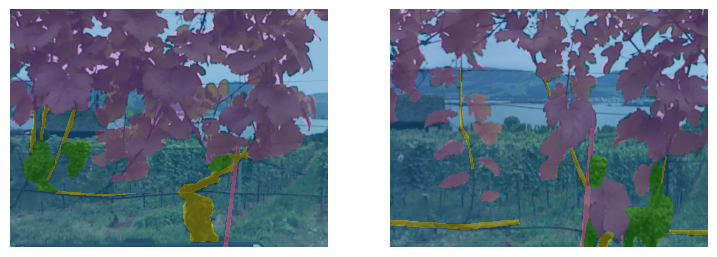

In [ ]:
cv = SelfMix(holes_num = 1, p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cv) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cv.x, cv.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 2, 3]:
    for roi_class in [-1, 1]:
        tm = SelfMix(holes_num, roi_class)
        learner_hparams["cbs"] = [esc, tm]
        r = evaluate(db_hparams,
                     dls_hparams,
                     technique,
                     learner_hparams,
                     learning_hparams,
                     learning_mode,
                     saving_hparams,
                     verbose = True
                    )
        results.update({
            str(holes_num) + str(roi_class): r["DiceMulti"]
        })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.968525,0.513665,0.349081,00:21
1,0.675595,0.384673,0.389185,00:19
2,0.612513,0.901246,0.278434,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.470970,0.358193,0.511728,00:19
1,0.395905,0.309807,0.671828,00:20
2,0.364659,0.294748,0.714794,00:20
3,0.328988,0.310199,0.751518,00:20
4,0.320397,0.320947,0.637736,00:20
5,0.333146,0.320055,0.726464,00:20
6,0.319837,0.281159,0.783929,00:20
7,0.306319,0.283879,0.772593,00:20
8,0.299048,0.275773,0.746815,00:20
9,0.283282,0.270747,0.788782,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.18916793167591095  /  DiceMulti: 0.8577938643840264  
Saving best model because DiceMulti 0.8578 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.915344,0.707879,0.291442,00:20
1,0.665102,0.557887,0.361600,00:20
2,0.616991,0.633271,0.436397,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.413241,0.340926,0.598248,00:21
1,0.377970,0.327895,0.648440,00:21
2,0.360728,0.293913,0.768662,00:20
3,0.332379,0.287498,0.776560,00:21
4,0.316570,0.268630,0.768834,00:21
5,0.309449,0.301605,0.773930,00:21
6,0.315710,0.280195,0.776214,00:20
7,0.301220,0.272928,0.765082,00:21
8,0.298002,0.281585,0.809159,00:21
9,0.280036,0.256595,0.820288,00:20


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.1725352257490158  /  DiceMulti: 0.8712814903850102  
Saving best model because DiceMulti 0.8713 >= 0.8578.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.929801,0.524060,0.345786,00:20
1,0.643580,0.394364,0.496486,00:20
2,0.947420,0.864600,0.226241,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.555348,0.425524,0.352600,00:21
1,0.474016,0.380411,0.511652,00:21
2,0.428592,0.372398,0.502850,00:21
3,0.393173,0.324577,0.656143,00:21
4,0.361690,0.348376,0.714407,00:20
5,0.343356,0.311035,0.715549,00:20
6,0.335775,0.332991,0.735638,00:21
7,0.316118,0.286111,0.774772,00:21
8,0.296720,0.336473,0.737498,00:21
9,0.285521,0.274286,0.770419,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.196217343211174  /  DiceMulti: 0.810993484608533  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.049643,0.673242,0.330290,00:20
1,0.743935,0.400345,0.383688,00:20
2,0.669557,0.579753,0.360678,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.467155,0.340469,0.529224,00:21
1,0.421059,0.276006,0.619741,00:21
2,0.378812,0.244370,0.777811,00:21
3,0.354452,0.256983,0.786444,00:21
4,0.331812,0.242992,0.802730,00:21
5,0.321488,0.242186,0.743315,00:21
6,0.315246,0.230590,0.789201,00:21
7,0.304114,0.239185,0.804481,00:21
8,0.294806,0.233976,0.819654,00:21
9,0.297031,0.229412,0.789027,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.1660422533750534  /  DiceMulti: 0.8827813895190154  
Saving best model because DiceMulti 0.8828 >= 0.8713.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.095338,0.722623,0.298616,00:20
1,0.758500,0.718522,0.337003,00:21
2,0.722785,0.620898,0.333710,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.458013,0.441406,0.504156,00:21
1,0.409186,0.369785,0.539425,00:21
2,0.375080,0.335478,0.714144,00:21
3,0.352292,0.295478,0.692248,00:21
4,0.369912,0.342882,0.620898,00:21
5,0.347806,0.284871,0.766360,00:21
6,0.317185,0.273925,0.782521,00:21
7,0.307112,0.263530,0.802837,00:21
8,0.308436,0.278081,0.802549,00:21
9,0.298428,0.261789,0.785942,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2607041001319885  /  DiceMulti: 0.7772693431463937  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.011395,0.750086,0.302175,00:20
1,0.683684,0.589852,0.334205,00:21
2,0.918147,1.221366,0.136066,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.569749,0.632657,0.319688,00:21
1,0.456159,0.446679,0.522389,00:21
2,0.394952,0.546209,0.559735,00:21
3,0.349796,0.425519,0.644375,00:21
4,0.320278,0.397944,0.667962,00:21
5,0.300973,0.467603,0.688574,00:21
6,0.295022,0.454740,0.668915,00:21
7,0.280159,0.452199,0.666835,00:21
8,0.264878,0.376864,0.699323,00:21
9,0.257097,0.367411,0.739241,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.16328667104244232  /  DiceMulti: 0.8776949429261887  
Saving best model because DiceMulti 0.8777 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.920813,0.565880,0.346046,00:20
1,0.669844,0.442622,0.424903,00:21
2,0.547651,0.383733,0.529503,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.375403,0.376900,0.605308,00:21
1,0.369795,0.326567,0.628448,00:21
2,0.340104,0.279268,0.775602,00:21
3,0.334670,0.478543,0.580159,00:21
4,0.333261,0.275695,0.776270,00:21
5,0.309699,0.294988,0.751734,00:21
6,0.303682,0.272060,0.784047,00:21
7,0.290659,0.260295,0.797936,00:21
8,0.300778,0.331286,0.768054,00:21
9,0.294452,0.251292,0.814020,00:21


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.1585809886455536  /  DiceMulti: 0.8805918109957886  
Saving best model because DiceMulti 0.8806 >= 0.8777.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.898816,0.478044,0.347725,00:20
1,0.757012,0.509711,0.346608,00:21
2,0.672811,0.985397,0.270605,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.533899,0.396567,0.421235,00:21
1,0.447033,0.375980,0.506973,00:21
2,0.398027,0.320647,0.652525,00:21
3,0.373100,0.299669,0.730762,00:21
4,0.345643,0.342286,0.749730,00:21
5,0.335196,0.307087,0.765226,00:21
6,0.308799,0.303317,0.773723,00:21
7,0.302839,0.285154,0.787248,00:21
8,0.285724,0.285391,0.801010,00:21
9,0.284768,0.283050,0.788295,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.15732063353061676  /  DiceMulti: 0.8827200897844563  
Saving best model because DiceMulti 0.8827 >= 0.8806.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.938659,0.622377,0.356990,00:20
1,0.708819,0.375029,0.367244,00:21
2,0.597500,0.316149,0.549501,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.427279,0.281759,0.653560,00:21
1,0.393960,0.286742,0.721258,00:21
2,0.358265,0.253853,0.798589,00:21
3,0.342832,0.262155,0.743295,00:21
4,0.330510,0.227909,0.796869,00:21
5,0.312323,0.220906,0.807598,00:21
6,0.304335,0.228983,0.792798,00:21
7,0.304088,0.279031,0.803711,00:21
8,0.298720,0.232362,0.800687,00:21
9,0.298087,0.219970,0.812841,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2405267208814621  /  DiceMulti: 0.8250322959816699  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.171935,0.717993,0.314061,00:20
1,0.757567,0.519336,0.407883,00:21
2,0.608286,0.419476,0.442491,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.388704,0.352662,0.597233,00:21
1,0.362875,0.335528,0.694010,00:21
2,0.344264,0.300153,0.762951,00:21
3,0.327598,0.269091,0.785730,00:21
4,0.315475,0.293406,0.796435,00:21
5,0.313364,0.284839,0.802995,00:21
6,0.304909,0.318532,0.766429,00:21
7,0.318056,0.323028,0.629906,00:21
8,0.309890,0.285729,0.789449,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3186485767364502  /  DiceMulti: 0.7608132195616891  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.078120,0.644331,0.310891,00:20
1,0.679883,0.490718,0.400031,00:21
2,0.575179,0.516110,0.322375,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.352967,0.456281,0.618857,00:21
1,0.319463,0.388575,0.661463,00:21
2,0.296029,0.413477,0.674293,00:21
3,0.279070,0.391211,0.709467,00:21
4,0.266067,0.373428,0.686266,00:21
5,0.275068,0.457846,0.677942,00:21
6,0.262710,0.389865,0.678462,00:21
7,0.263824,0.394704,0.710516,00:21
8,0.280207,0.407721,0.590149,00:21
9,0.266978,0.509789,0.679713,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2168615460395813  /  DiceMulti: 0.8189045909240911  
Saving best model because DiceMulti 0.8189 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.841982,0.484753,0.349263,00:21
1,0.677046,0.538207,0.340119,00:21
2,0.708069,0.783757,0.256208,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.502131,0.449462,0.390737,00:21
1,0.432426,0.339275,0.609557,00:21
2,0.397986,0.306010,0.691037,00:21
3,0.375004,0.297235,0.767436,00:21
4,0.361309,0.309773,0.765757,00:21
5,0.336170,0.282584,0.779958,00:21
6,0.320534,0.306051,0.768378,00:21
7,0.313238,0.275348,0.783917,00:21
8,0.301035,0.282198,0.763345,00:21
9,0.287441,0.262347,0.800036,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.22968843579292297  /  DiceMulti: 0.8345851885431438  
Saving best model because DiceMulti 0.8346 >= 0.8189.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.031048,0.569040,0.336020,00:21
1,0.812374,0.684602,0.259562,00:21
2,0.668692,0.467826,0.445059,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.417990,0.354429,0.570602,00:21
1,0.377146,0.319505,0.687819,00:21
2,0.348803,0.319922,0.735668,00:21
3,0.327777,0.287971,0.756873,00:21
4,0.336918,0.337665,0.752881,00:21
5,0.334543,0.292846,0.785522,00:21
6,0.307540,0.370034,0.753819,00:21
7,0.298024,0.275042,0.790777,00:21
8,0.298763,0.292532,0.735234,00:21
9,0.288302,0.280905,0.775241,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.199677512049675  /  DiceMulti: 0.8558142032679623  
Saving best model because DiceMulti 0.8558 >= 0.8346.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.924978,0.714669,0.335480,00:21
1,0.670897,0.438480,0.427326,00:21
2,0.742165,0.548727,0.444298,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.455856,0.308215,0.582706,00:21
1,0.408591,0.282449,0.665326,00:21
2,0.381422,0.271628,0.618732,00:21
3,0.369135,0.247718,0.700248,00:21
4,0.349239,0.255630,0.759761,00:21
5,0.327418,0.249856,0.804466,00:21
6,0.338939,0.291601,0.663560,00:21
7,0.333757,0.258412,0.727004,00:21
8,0.321227,0.245500,0.795179,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.26001685857772827  /  DiceMulti: 0.7825379756693425  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.855344,0.627524,0.343948,00:20
1,0.669057,0.788125,0.341178,00:21
2,0.575075,0.784210,0.325052,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.399271,0.373638,0.495260,00:21
1,0.365786,0.313717,0.604929,00:21
2,0.349856,0.358596,0.700309,00:21
3,0.330362,0.301286,0.770289,00:21
4,0.320903,0.285754,0.768305,00:21
5,0.323860,0.284698,0.768796,00:21
6,0.302574,0.274384,0.812275,00:21
7,0.286604,0.265935,0.784672,00:21
8,0.280536,0.265421,0.767491,00:21
9,0.270265,0.286234,0.811006,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.24160391092300415  /  DiceMulti: 0.8043225285081975  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.893307,0.707245,0.307024,00:20
1,0.620563,0.797446,0.290418,00:21
2,0.545683,0.741136,0.251337,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.387039,0.427462,0.612108,00:21
1,0.335646,0.403146,0.648537,00:21
2,0.313464,0.377219,0.699490,00:21
3,0.294512,0.402052,0.718095,00:21
4,0.282288,0.500778,0.648702,00:21
5,0.279074,0.624170,0.679277,00:21
6,0.265235,0.431044,0.665962,00:21
7,0.256775,0.383046,0.725089,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.2232951670885086  /  DiceMulti: 0.8244532744889257  
Saving best model because DiceMulti 0.8245 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.958806,0.689484,0.305825,00:20
1,0.697867,0.472011,0.347483,00:20
2,0.687079,0.697843,0.288036,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.472355,0.378216,0.480932,00:21
1,0.423053,0.424236,0.491182,00:21
2,0.423772,0.334567,0.576046,00:21
3,0.384912,0.326502,0.661431,00:21
4,0.362955,0.316807,0.752018,00:21
5,0.345162,0.298022,0.790693,00:21
6,0.319185,0.281035,0.791394,00:21
7,0.296613,0.258070,0.794958,00:21
8,0.295024,0.322501,0.793631,00:21
9,0.289304,0.262750,0.785415,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.22466802597045898  /  DiceMulti: 0.8443009044675588  
Saving best model because DiceMulti 0.8443 >= 0.8245.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.980525,0.749829,0.331584,00:20
1,0.790233,0.544607,0.328621,00:20
2,0.740131,0.877286,0.251982,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.500030,0.401309,0.429072,00:21
1,0.436099,0.361679,0.541322,00:21
2,0.395177,0.338145,0.581460,00:21
3,0.370719,0.315350,0.707726,00:21
4,0.353005,0.339086,0.620865,00:21
5,0.337624,0.321023,0.724311,00:21
6,0.325338,0.390482,0.609012,00:21
7,0.322514,0.300592,0.763631,00:21
8,0.312476,0.316722,0.757338,00:21
9,0.287216,0.298178,0.731148,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.1625758707523346  /  DiceMulti: 0.8666845043610201  
Saving best model because DiceMulti 0.8667 >= 0.8443.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.842209,0.509519,0.356859,00:20
1,0.633298,0.343894,0.433883,00:21
2,0.903580,2.857964,0.175938,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.971812,0.400771,0.361303,00:21
1,0.636759,0.332819,0.420108,00:21
2,0.507645,0.315160,0.435433,00:21
3,0.435059,0.264663,0.705626,00:21
4,0.388942,0.262636,0.711725,00:21
5,0.357886,0.250896,0.735056,00:21
6,0.352745,0.247968,0.799018,00:21
7,0.332175,0.245616,0.777596,00:21
8,0.309414,0.235645,0.799927,00:21
9,0.297843,0.303701,0.786157,00:21


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.16111862659454346  /  DiceMulti: 0.8810002537849282  
Saving best model because DiceMulti 0.881 >= 0.8667.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.993454,0.598024,0.349798,00:20
1,0.681239,0.421660,0.395198,00:21
2,0.625983,0.571871,0.353119,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.458754,0.426574,0.546403,00:21
1,0.428260,0.342743,0.567750,00:21
2,0.388282,0.328578,0.723464,00:21
3,0.355390,0.294018,0.714980,00:21
4,0.329426,0.345120,0.611411,00:21
5,0.316853,0.282447,0.780348,00:21
6,0.305432,0.455579,0.657976,00:21
7,0.302966,0.259368,0.810893,00:21
8,0.288857,0.264278,0.795841,00:21
9,0.281433,0.317776,0.800797,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2475217580795288  /  DiceMulti: 0.767024318289798  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.880026,0.636098,0.306997,00:20
1,0.688267,0.724513,0.336858,00:21
2,0.582640,0.608152,0.342457,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.367529,0.437129,0.594130,00:21
1,0.323803,0.421395,0.617431,00:21
2,0.302782,0.419783,0.700096,00:21
3,0.283917,0.391885,0.668828,00:21
4,0.283112,0.427746,0.703211,00:21
5,0.277752,0.471226,0.673050,00:21
6,0.266541,0.367336,0.711599,00:21
7,0.255063,0.589470,0.709625,00:21
8,0.256598,0.440745,0.696676,00:21
9,0.250082,0.438783,0.712494,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.18735766410827637  /  DiceMulti: 0.8513395517263579  
Saving best model because DiceMulti 0.8513 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.909979,0.661162,0.340892,00:21
1,0.646424,0.431563,0.353632,00:21
2,0.715238,0.731996,0.310746,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.509491,0.434306,0.405983,00:21
1,0.432506,0.355103,0.553139,00:21
2,0.384835,0.295731,0.718651,00:21
3,0.364793,0.293940,0.720483,00:21
4,0.330601,0.273259,0.789893,00:21
5,0.323287,0.283119,0.736192,00:21
6,0.331850,0.337926,0.795015,00:21
7,0.319578,0.297857,0.781852,00:21
8,0.300681,0.267275,0.801520,00:21
9,0.277808,0.256376,0.806727,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.18972378969192505  /  DiceMulti: 0.869888795633478  
Saving best model because DiceMulti 0.8699 >= 0.8513.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.850427,0.533373,0.346795,00:21
1,0.660237,0.546173,0.346576,00:21
2,0.724036,0.895968,0.226809,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.499849,0.415586,0.557722,00:21
1,0.430582,0.350305,0.564722,00:21
2,0.386769,0.322349,0.649505,00:22
3,0.357561,0.306263,0.736410,00:21
4,0.334301,0.299044,0.681514,00:21
5,0.318956,0.299540,0.727740,00:21
6,0.322339,0.321539,0.749455,00:21
7,0.305085,0.295168,0.782559,00:21
8,0.291815,0.336884,0.688865,00:21
9,0.280452,0.265696,0.803283,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.20950083434581757  /  DiceMulti: 0.8657634246068536  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.875193,0.506442,0.350283,00:21
1,0.630424,0.305601,0.456254,00:21
2,0.522803,0.356993,0.463066,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.378473,0.273550,0.666794,00:21
1,0.348715,0.257580,0.739544,00:21
2,0.342134,0.240387,0.774501,00:21
3,0.321725,0.240006,0.800763,00:21
4,0.306205,0.295471,0.758015,00:21
5,0.317694,0.300854,0.735468,00:21
6,0.306563,0.250524,0.799594,00:21
7,0.290966,0.250210,0.815414,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.23868028819561005  /  DiceMulti: 0.835295494254445  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.888932,0.695021,0.326726,00:20
1,0.617117,0.470618,0.360486,00:21
2,0.602970,0.650612,0.338381,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.460169,0.397508,0.492020,00:21
1,0.403244,0.338552,0.646639,00:21
2,0.371254,0.302023,0.737328,00:21
3,0.341523,0.317558,0.712693,00:21
4,0.328949,0.273574,0.793359,00:21
5,0.315819,0.339068,0.778404,00:21
6,0.315586,0.310968,0.784958,00:21
7,0.310723,0.305859,0.782563,00:21
8,0.291766,0.263767,0.800095,00:21
9,0.274983,0.273388,0.820934,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.3094913959503174  /  DiceMulti: 0.7678740907340218  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.021991,0.700048,0.295957,00:21
1,0.670121,0.618955,0.300415,00:21
2,0.590781,0.627146,0.319936,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.429634,0.485743,0.393524,00:21
1,0.374015,0.475580,0.549424,00:21
2,0.341494,0.404094,0.687951,00:21
3,0.310941,0.526540,0.670716,00:21
4,0.303430,0.396950,0.692461,00:21
5,0.298745,0.419391,0.690452,00:21
6,0.278835,0.363109,0.722467,00:21
7,0.270819,0.405095,0.716907,00:21
8,0.256737,0.382508,0.734261,00:21
9,0.252682,0.399053,0.721082,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.20218943059444427  /  DiceMulti: 0.8399901256735582  
Saving best model because DiceMulti 0.84 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.823412,0.600475,0.350962,00:20
1,0.630716,0.460012,0.353535,00:21
2,0.924735,0.902536,0.270604,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.554282,0.483945,0.398118,00:21
1,0.463692,0.427854,0.415964,00:21
2,0.415060,0.346925,0.486069,00:21
3,0.389408,0.315493,0.630383,00:21
4,0.366559,0.300698,0.721375,00:21
5,0.340137,0.289606,0.777116,00:21
6,0.328682,0.286872,0.744603,00:21
7,0.310383,0.327045,0.770852,00:21
8,0.309544,0.273658,0.788967,00:21
9,0.299976,0.284912,0.764749,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.1825409233570099  /  DiceMulti: 0.8624881686951775  
Saving best model because DiceMulti 0.8625 >= 0.84.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.870873,0.751189,0.300287,00:20
1,0.746839,0.527123,0.346581,00:21
2,0.597389,0.468494,0.479521,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.371503,0.332021,0.636048,00:21
1,0.341094,0.323620,0.726148,00:21
2,0.340671,0.324468,0.689564,00:21
3,0.333212,0.299410,0.756204,00:21
4,0.313593,0.337441,0.753005,00:21
5,0.302831,0.273690,0.778204,00:21
6,0.282621,0.276135,0.753071,00:21
7,0.282218,0.332741,0.725834,00:21
8,0.287580,0.301581,0.776095,00:21
9,0.277083,0.258831,0.812818,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.14988306164741516  /  DiceMulti: 0.878975120225004  
Saving best model because DiceMulti 0.879 >= 0.8625.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.038840,0.623905,0.338130,00:20
1,0.697898,0.369404,0.362565,00:21
2,0.619621,0.720201,0.319837,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.447619,0.296259,0.598384,00:21
1,0.390614,0.258571,0.672964,00:21
2,0.351441,0.254510,0.782905,00:21
3,0.336872,0.276044,0.758231,00:21
4,0.325110,0.255286,0.785710,00:21
5,0.317270,0.229501,0.807868,00:21
6,0.303474,0.252094,0.803307,00:21
7,0.298957,0.225348,0.824255,00:21
8,0.288494,0.219426,0.832307,00:21
9,0.278887,0.302315,0.813334,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.15967226028442383  /  DiceMulti: 0.8872441120231457  
Saving best model because DiceMulti 0.8872 >= 0.879.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.896837,0.686458,0.341398,00:21
1,0.627523,0.480742,0.393641,00:21
2,0.648328,1.017409,0.177844,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.499780,0.423311,0.392550,00:21
1,0.423315,0.331898,0.691488,00:21
2,0.382434,0.335564,0.730815,00:21
3,0.344350,0.341555,0.738539,00:21
4,0.351019,0.297847,0.735029,00:21
5,0.330762,0.372714,0.760444,00:21
6,0.329597,0.299638,0.779712,00:21
7,0.318969,0.275505,0.797264,00:21
8,0.293724,0.302119,0.765573,00:21
9,0.286358,0.262907,0.794017,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.20206479728221893  /  DiceMulti: 0.8407171996552192  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,1-1,11,2-1,21,3-1,31
0,0.857794,0.877695,0.818905,0.824453,0.851340,0.839990
1,0.871281,0.880592,0.834585,0.844301,0.869889,0.862488
2,0.810993,0.882720,0.855814,0.866685,0.865763,0.878975
3,0.882781,0.825032,0.782538,0.881000,0.835295,0.887244
4,0.777269,0.760813,0.804323,0.767024,0.767874,0.840717


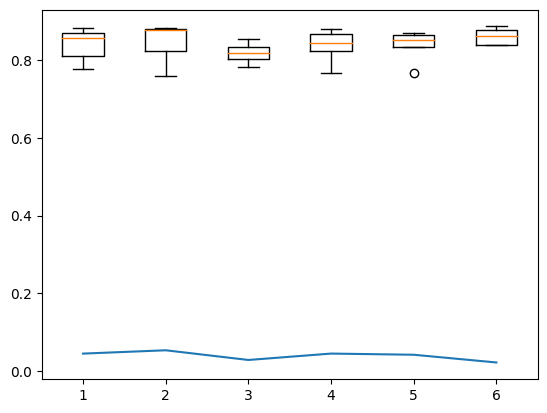

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
1-1,0.840024,0.044446
11,0.845370,0.053019
2-1,0.819233,0.028030
21,0.836693,0.044509
3-1,0.838032,0.041505
31,0.861883,0.021581


We save the results in order to plot them together.

In [ ]:
folds = [["SM" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("SelfMix")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


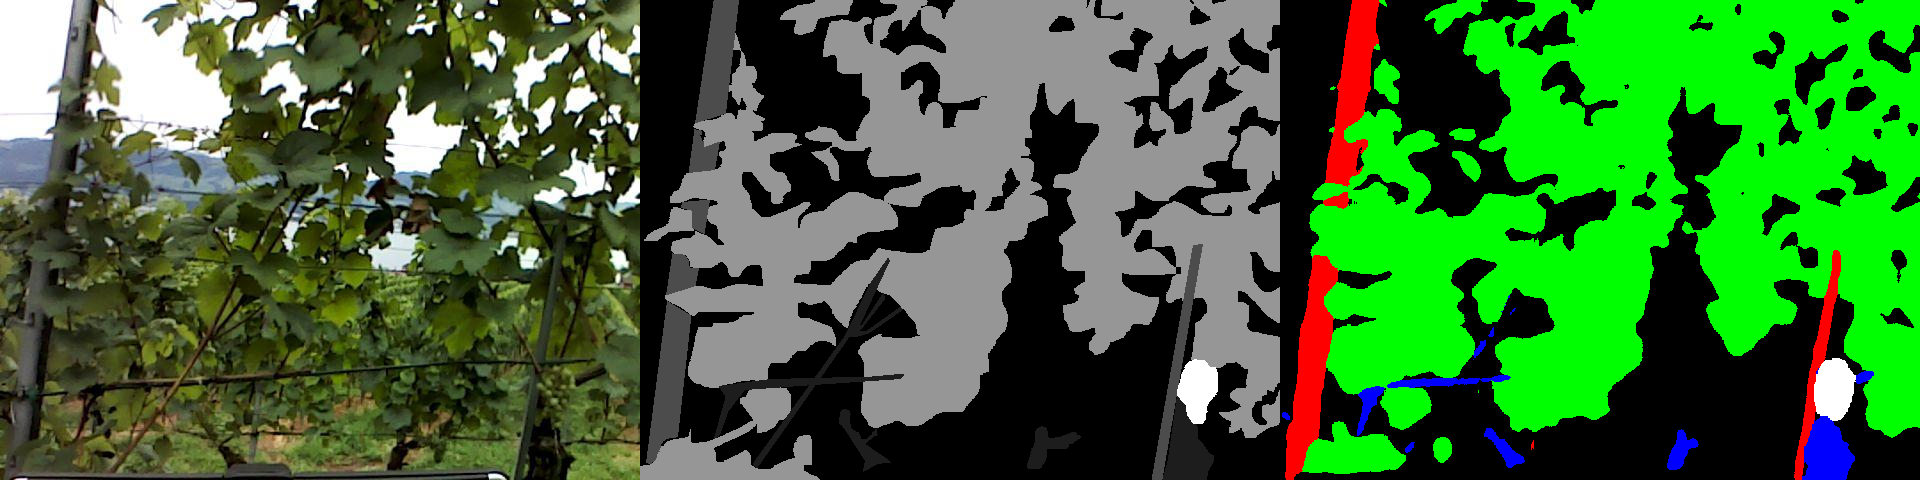

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

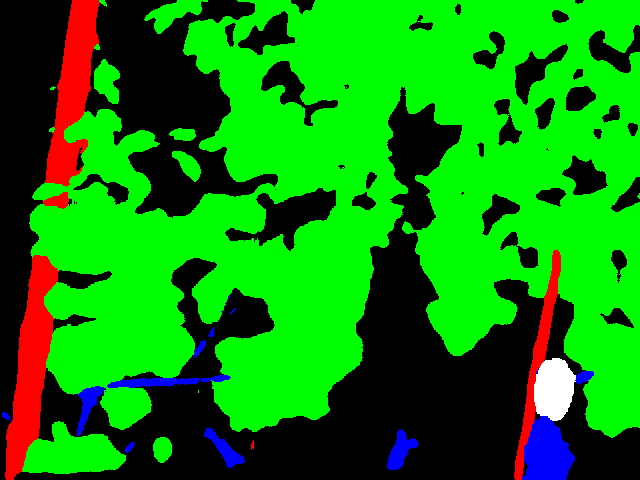

In [ ]:
mask